<a href="https://colab.research.google.com/github/seonghunYang/face-recognition/blob/main/%EC%98%81%EC%83%81_%EC%96%BC%EA%B5%B4_%EC%8B%9D%EB%B3%84_%EB%AA%A8%EB%93%88_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##얼굴 식별 파이프라인
1. face detection
2. face alignment 및 정규화
3. face representation
4. face verification

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd drive/MyDrive/i-mind-face-recognition

Mounted at /content/drive
/content/drive/MyDrive/i-mind-face-recognition


In [2]:
from deepface.commons import functions, distance as dst
from deepface import DeepFace
from retinaface import RetinaFace
import time
import cv2
import matplotlib.pyplot as plt

In [ ]:
!pip install wandb
import wandb
wandb

In [ ]:
wandb.init()

In [7]:
!watch -n 1 nvidia-smi

>

#face detection

In [3]:
# 이미지 사진 보여주고, rgb 변환한 값 return
def showImg(img_path):
  img_arr  = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(8, 8))
  plt.imshow(img_arr)
  return img_arr

def drawFrameWithBbox(frame, detected_faces, labels):
  draw_frame = frame.copy()
  idx = 0
  for key in detected_faces.keys():
    face = detected_faces[key]
    face_area = face['facial_area']
    left = face_area[0]
    top = face_area[1]
    right = face_area[2]
    bottom = face_area[3]

    cv2.rectangle(draw_frame, (left, top), (right, bottom), (255, 0, 0), 1)
    cv2.putText(draw_frame, labels[idx], (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    landmarks = face['landmarks']
    # landmark 표시
    for key in landmarks:
      cv2.circle(draw_frame, tuple(landmarks[key]), 1, (255, 0, 0), -1)
    idx += 1
  return draw_frame

#face alignment / normalization
1. face crop
2. face alignment
3. face resize and normalization

In [4]:
from retinaface.commons import postprocess
import numpy as np
from keras.preprocessing import image

In [5]:
def cropFace(img, area):
  img_copy = img.copy()
  left = area[0]
  top = area[1]
  right = area[2]
  bottom = area[3]
  return img_copy[top: bottom, left: right]

def alignFace(img, landmarks):
  left_eye = landmarks["left_eye"]
  right_eye = landmarks["right_eye"]
  nose = landmarks["nose"]
  mouth_right = landmarks["mouth_right"]
  mouth_left = landmarks["mouth_left"]
  img = postprocess.alignment_procedure(img, right_eye, left_eye, nose)
  return img[:, :, ::-1]

def resizeFace(img, target_size=(112, 112)):
  factor_0 = target_size[0] / img.shape[0]
  factor_1 = target_size[1] / img.shape[1]
  factor = min(factor_0, factor_1)

  dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
  img = cv2.resize(img, dsize)

  diff_0 = target_size[0] - img.shape[0]
  diff_1 = target_size[1] - img.shape[1]
  img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
  
  if img.shape[0:2] != target_size:
    img = cv2.resize(img, target_size)
  
  img_pixels = image.img_to_array(img)
  img_pixels = np.expand_dims(img_pixels, axis = 0)
  img_pixels /= 255 #normalize input in [0, 1]

  return img_pixels

In [6]:
def processFrame(frame, faces):
  result = []
  for key in faces.keys():
    face = faces[key]
    facial_area = face['facial_area']
    # 얼굴 자르기
    crop_face = cropFace(frame, facial_area)
    # 얼굴 정렬
    landmarks = face['landmarks']
    align_face = alignFace(crop_face, landmarks)
    #resize
    resize_face = resizeFace(align_face)
    result.append(resize_face)
  return result

#face representation and verification

In [24]:
import os
from deepface.basemodels import ArcFace

def createEmbedingDB(db_folder_path, img_show=False):
  db = {
      "labels": [],
      "embeding": []
  }
  model = ArcFace.loadModel()

  face_folders = os.listdir(db_folder_path)
  for face_folder in face_folders:
    label = face_folder
    img_folder_path = db_folder_path + "/" + face_folder
    img_folders = os.listdir(img_folder_path)

    for img_path in img_folders:
      img = cv2.imread(img_folder_path + "/" + img_path)
      faces = RetinaFace.detect_faces(img_path=img)
      # bbox
      if (type(faces) == dict):
        process_face_imgs = processFrame(img, faces)
        # 임베딩
        for face_img in process_face_imgs:
          embedding_img = model.predict(face_img)[0]
          db["embeding"].append(embedding_img)
          db['labels'].append(label)
        if img_show:
          img_bbox = drawFrameWithBbox(img, faces, [label])
          plt.imshow(img_bbox)
          plt.show()
  return db



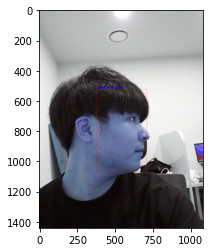

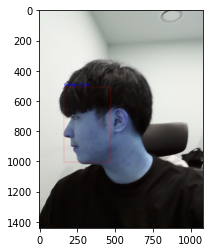

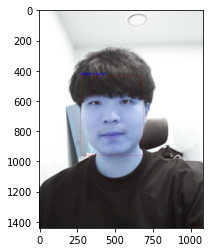

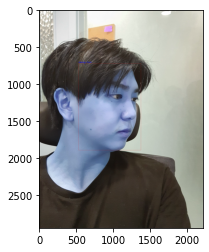

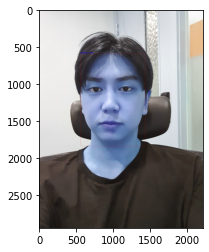

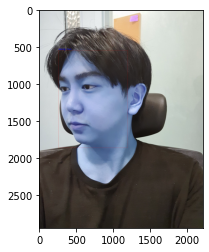

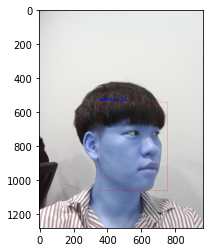

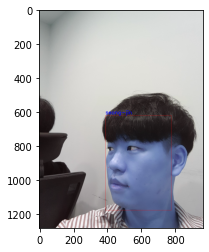

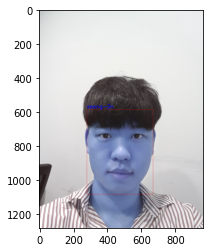

In [25]:
db = createEmbedingDB("/content/drive/MyDrive/i-mind-face-recognition/i-mind", img_show=True)

In [9]:
from deepface.commons import functions, distance as dst

def faceIdentify(img, db, model, metric="cosine"):
  img_embeding = model.predict(img)[0]
  min_distance = findThreshold(metric)
  label = 'unknown'

  for idx, db_embeding in enumerate(db['embeding']):
    distance = cosineDistance(img_embeding, db_embeding, metric)

    if distance <= min_distance:
      label = db['labels'][idx]
  return label

def cosineDistance(img1_embedding, img2_embedding, metric):
  if metric == 'cosine':
    distance = dst.findCosineDistance(img1_embedding, img2_embedding)
  elif metric == 'euclidean':
    distance = dst.findEuclideanDistance(img1_embedding, img2_embedding)
  elif metric == 'euclidean_l2':
    distance = dst.findEuclideanDistance(dst.l2_normalize(img1_embedding), dst.l2_normalize(img2_embedding))
  return distance

def findThreshold(metric):
   if metric == 'cosine':
      return 0.6871912959056619
   elif metric == 'euclidean':
      return 4.1591468986978075
   elif metric == 'euclidean_l2':
      return 1.1315718048269017

In [15]:
def faecRecognition(input_path, output_path, db):

  cap = cv2.VideoCapture(input_path)

  codec = cv2.VideoWriter_fourcc(*'XVID')

  vid_fps = cap.get(cv2.CAP_PROP_FPS)
  vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

  vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

  frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print("총 Frame 갯수: ", frame_cnt)
  btime = time.time()

  # retinaface model load
  detect_model = RetinaFace.build_model()
  identify_model = ArcFace.loadModel()
  frame_idx = 0
  while True:
    hasFrame, img_frame = cap.read()
    if not hasFrame:
      print('처리 완료')
      break
    stime = time.time()
    #retinaface로 얼굴 detection
    faces = RetinaFace.detect_faces(img_path=img_frame, model=detect_model)
    # bbox
    if (type(faces) == dict):
      process_face_imgs = processFrame(img_frame, faces)
      identities = []
      for face_img in process_face_imgs:
        identity = faceIdentify(face_img, db, identify_model)
        identities.append(identity)
      img_frame = drawFrameWithBbox(img_frame, faces, identities)

    print('frame별 detection 수행 시간:', round(time.time() - stime, 4),frame_idx)
    frame_idx += 1
    vid_writer.write(img_frame)

  vid_writer.release()
  cap.release()

  print("최종 완료 수행 시간: ", round(time.time() - btime, 4))

In [14]:
faecRecognition("./shotforlove_face_test.mp4", "./shotforlove_face_result.mp4", db)

총 Frame 갯수:  2513
frame별 detection 수행 시간: 2.805 0
frame별 detection 수행 시간: 0.6474 1
frame별 detection 수행 시간: 0.6442 2
frame별 detection 수행 시간: 0.6174 3
frame별 detection 수행 시간: 0.6425 4
frame별 detection 수행 시간: 0.6006 5
frame별 detection 수행 시간: 0.6481 6
frame별 detection 수행 시간: 0.6419 7
frame별 detection 수행 시간: 0.679 8
frame별 detection 수행 시간: 0.7318 9
frame별 detection 수행 시간: 0.7557 10
frame별 detection 수행 시간: 0.7987 11
frame별 detection 수행 시간: 0.8006 12
frame별 detection 수행 시간: 0.7948 13
frame별 detection 수행 시간: 0.8137 14
frame별 detection 수행 시간: 0.8688 15
frame별 detection 수행 시간: 0.8511 16
frame별 detection 수행 시간: 0.8347 17
frame별 detection 수행 시간: 0.8728 18
frame별 detection 수행 시간: 0.9288 19
frame별 detection 수행 시간: 0.8283 20
frame별 detection 수행 시간: 0.7955 21
frame별 detection 수행 시간: 0.7959 22
frame별 detection 수행 시간: 0.7896 23
frame별 detection 수행 시간: 0.7474 24
frame별 detection 수행 시간: 0.8284 25
frame별 detection 수행 시간: 0.8094 26
frame별 detection 수행 시간: 0.7856 27
frame별 detection 수행 시간: 0.7516 28
frame별 d